In [7]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import pandas as pd
import rdata
import csv

In [8]:
def create_maldi_image(spectra_list):
    # Get the dimensions of the image
    n = int(math.sqrt(len(spectra_list)))
    # Create an empty numpy array to store the maldi image
    maldi_image = np.zeros((n, n))
    
    # Loop over each pixel in the image and assign the corresponding spectra
    for row in range(n):
        for col in range(n):
            avg_value = np.sum(spectra_list[row * n + col]) / len(spectra_list[row * n + col])
            #maldi_image[row, col] = int(avg_value * 255)
            maldi_image[row, col] = np.round(avg_value * 255).astype(np.uint8)
            
    return maldi_image

In [9]:
def plot_image(image):
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()
    
def plot_images(images_list, labels):
    n = round(math.sqrt(len(images_list)))
    fig, axes = plt.subplots(nrows=n, ncols=n, figsize=(10, 10))
    for i in range(n):
        for j in range(n):
            axes[i, j].imshow(create_maldi_image(images_list[i*n+j]), cmap='gray')
            axes[i, j].axis('off')
            axes[i, j].set_title(labels[i*n+j])
    plt.savefig('plot.png')
    plt.show()

In [10]:
def recursionStart(spectra):
    featurePairs = []
    maxima = []
    minima = []
    
    for i in range(1, len(spectra) - 1):
        if spectra[i] > spectra[i-1]:
            if spectra[i] >= spectra[i+1]:
                for j in range(i+1, len(spectra)):
                    if spectra[i] > spectra[j]:
                        maxima.append([i, spectra[i]])
                        break
                    elif spectra[i] < spectra[j]:
                        break
        if spectra[i] < spectra[i-1]:
            if spectra[i] <= spectra[i+1]:
                for j in range(i+1, len(spectra)):
                    if spectra[i] < spectra[j]:
                        minima.append([i, spectra[i]])
                        break
                    elif spectra[i] > spectra[j]:
                        break
    maxima.sort(key = lambda element: element[1], reverse = True)
    minima.sort(key = lambda element: element[1])
    
    if len(maxima) == 0:
        return -1
    globalMaxima = maxima.pop(0)
    featurePairs.append([globalMaxima[0], globalMaxima[1] - minima[0][1]])
    
    recursionStep(0, globalMaxima[0], maxima.copy(), minima.copy(), featurePairs)
    recursionStep(len(spectra) - 1, globalMaxima[0], maxima.copy(), minima.copy(), featurePairs)
    
    return featurePairs

def recursionStep(start, end, maxima, minima, featurePairs):
    factor = 1
    if end < start:
        factor = -1
    currentMaxima = []
    for i in range(len(maxima)):
        position = maxima[i][0]
        if start * factor < position * factor and position * factor < end * factor:
            currentMaxima.append(maxima[i])
    if len(currentMaxima) == 0:
        return
    localMaxima = currentMaxima.pop(0)
    recursionStep(start, localMaxima[0], currentMaxima.copy(), minima.copy(), featurePairs)
    currentMinima = []
    for i in range(len(minima)):
        position = minima[i][0]
        if localMaxima[0] * factor < position * factor and position * factor < end * factor:
            currentMinima.append(minima[i])
    localMinima = currentMinima.pop(0)
    featurePairs.append([localMaxima[0], localMaxima[1] - localMinima[1]])
    recursionStep(localMinima[0], localMaxima[0], currentMaxima.copy(), currentMinima.copy(), featurePairs)
    recursionStep(localMinima[0], end, currentMaxima.copy(), currentMinima.copy(), featurePairs)
    
def getPersistenceTransformation_old(data_X, listOfK):
    spectras = []
    for i in range(len(data_X)):
        featurePairs = recursionStart(data_X.iloc[i])
        if featurePairs == -1:
            spectras.append([[0,0]])
        else:
            featurePairs.sort(key = lambda element: element[1], reverse = True)
            spectras.append(featurePairs)
        
    spectrasForEachK = []
    
    for k in listOfK:
        transformationForSpectra = []
        for i in range(0, len(spectras)):
            transformation = [0] * len(data_X.iloc[i])
            featurePairs = spectras[i][0:round(k*len(spectras[i]))]
            for x, fx in featurePairs:
                transformation[x] = fx
            transformationForSpectra.append(transformation)
        spectrasForEachK.append(transformationForSpectra)
    return spectrasForEachK

def getPersistenceTransformation(data_X, number_of_peaks):
    spectras = []
    for i in range(len(data_X)):
        featurePairs = recursionStart(data_X.iloc[i])
        if featurePairs == -1:
            spectras.append([[0,0]])
        else:
            featurePairs.sort(key = lambda element: element[1], reverse = True)
            spectras.append(featurePairs)
        

    transformationForSpectra = []
    for i in range(0, len(spectras)):
        transformation = [0] * len(data_X.iloc[i])
        if len(spectras[i]) == 1:
            k = 0
        else:
            k = number_of_peaks
        featurePairs = spectras[i][0:k]
        for x, fx in featurePairs:
            transformation[x] = fx
        transformationForSpectra.append(transformation)
    return transformationForSpectra

def getPersistenceTransformation2(data_X, listOfK):
    spectras = []
    for i in range(len(data_X)):
        featurePairs = recursionStart(data_X.iloc[i])
        if featurePairs == -1:
            spectras.append([[0,0]])
        else:
            featurePairs.sort(key = lambda element: element[1], reverse = True)
            spectras.append(featurePairs)

    spectrasForEachK = []
                
            
    for k in listOfK:
        transformationForSpectra = []
        for i in range(0, len(spectras)):
            if len(spectras[i]) == 1:
                var_k = 0
            else:
                var_k = k
            transformation = [0] * len(data_X.iloc[i])
            featurePairs = spectras[i][0:round(var_k*len(spectras[i]))]
            for x, fx in featurePairs:
                transformation[x] = fx
            transformationForSpectra.append(transformation)
        spectrasForEachK.append(transformationForSpectra)
    
    return spectrasForEachK

In [11]:
def read_data(path):
    parsed = rdata.parser.parse_file(path)
    converted = rdata.conversion.convert(parsed)
    data = np.array(list(converted.values()))[0]
    return data

In [12]:
def read_csv_data(path):
    # Read the CSV file
    #with open(path, "r") as csv_file:
    #    reader = csv.reader(csv_file)
    #    data = list(reader)

    # Convert the data to a NumPy array
    #np_data = np.array(data, dtype=float)

    # Print the NumPy array
    #return np_data
    
    # Load CSV file into NumPy array
    data = np.genfromtxt(path, delimiter=',', skip_header=1)
    return np.transpose(data[:, 1:])

In [13]:
def add_gaussian_noise(image, mean=0, std=1, seed=None):
    """Add Gaussian noise to a 2D numpy array."""
    if seed is not None:
        np.random.seed(seed)
    #noise = np.random.normal(mean, std, size=image.shape)
    noise = np.random.normal(loc=mean, scale=std, size=image.shape)
    return image + noise

In [14]:
def add_poisson_noise(matrix, lam=1, seed=None):
    """Add Poisson noise to a matrix.

    Args:
        matrix (numpy.ndarray): The matrix to add noise to.
        lam (float): The intensity parameter of the Poisson distribution.
        seed (int): The seed value for the random number generator.

    Returns:
        numpy.ndarray: The noisy matrix.

    """
    if seed is not None:
        np.random.seed(seed)

    noisy_matrix = np.random.poisson(lam=lam, size=matrix.shape)
    noisy_matrix = matrix + noisy_matrix.astype(np.float32)

    return noisy_matrix

In [15]:
def add_salt_noise(matrix, percentage):
    """
    Adds salt noise to a NumPy matrix.

    Parameters:
        matrix (np.ndarray): The matrix to add noise to.
        prob (float): The probability of a pixel being "salted".

    Returns:
        np.ndarray: The matrix with salt noise added.
    """
    # Create a copy of the matrix to modify
    noisy_matrix = np.copy(matrix)

    # Determine the number of pixels to salt
    num_pixels = int(percentage * len(matrix))

    # Generate a random set of indices for the pixels to salt
    indices = np.random.choice(len(matrix), size=num_pixels, replace=False)

    # Replace the pixels at the chosen indices with a high value (255)
    for ind in indices:
        for value in matrix[ind]:
            noisy_matrix[ind][int(value)] = 50.
    
    return noisy_matrix

In [16]:
def add_pepper_noise(matrix, percentage):
    """
    Adds pepper noise to a NumPy matrix.

    Parameters:
        matrix (np.ndarray): The matrix to add noise to.
        prob (float): The probability of a pixel being "peppered".

    Returns:
        np.ndarray: The matrix with pepper noise added.
    """
    # Create a copy of the matrix to modify
    noisy_matrix = np.copy(matrix)

    # Determine the number of pixels to pepper
    num_pixels = int(percentage * len(matrix))

    # Generate a random set of indices for the pixels to pepper
    indices = np.random.choice(len(matrix), size=num_pixels, replace=False)

    # Replace the pixels at the chosen indices with a low value (0)
    for ind in indices:
        for value in matrix[ind]:
            noisy_matrix[ind][int(value)] = 0.
    
    return noisy_matrix

In [17]:
def apply_pt(data, noise_type, list_of_k, lam = 0.1, mean = 0.1, std = 0.3, seed = 123, percentage = .05):
    labels1 = ['default', 'default', 'default', 'default']
    if noise_type == 'gaussian':
        noisy_data = add_gaussian_noise(data, mean=mean, std=std, seed=seed)
        labels1 = ['Ground Truth', 'pt of ground truth', '{} noise with mean = {:.1f} and std = {:.1f}'.format(noise_type, mean, std), 'pt of noisy image with fixed peaks']
    elif noise_type == 'poisson':
        noisy_data = add_poisson_noise(data, lam = lam, seed=seed)
        labels1 = ['Ground Truth', 'pt of ground truth', '{} noise with lam = {:.1f}'.format(noise_type, lam), 'pt of noisy image with fixed peaks']
    elif noise_type == 'salt':
        noisy_data = add_salt_noise(data, percentage)
        labels1 = ['Ground Truth', 'pt of ground truth', '{} noise with intensity of = {}%'.format(noise_type, percentage * 100), 'pt of noisy image with fixed peaks']
    elif noise_type == 'pepper':
        noisy_data = add_salt_noise(data, percentage)
        labels1 = ['Ground Truth', 'pt of ground truth', '{} noise with intensity of = {}%'.format(noise_type, percentage * 100), 'pt of noisy image with fixed peaks']
    else:
        noisy_data = add_gaussian_noise(data, mean=mean, std=std, seed=seed)
        labels1 = ['Ground Truth', 'pt of ground truth', '{} noise with mean = {:.1f} and std = {:.1f}'.format(noise_type, mean, std), 'pt of noisy image with fixed peaks']
        
        
    pt_data = getPersistenceTransformation(data_X = pd.DataFrame(data), number_of_peaks = 50)
    X = getPersistenceTransformation(data_X = pd.DataFrame(noisy_data), number_of_peaks = 50)

    
    plot_images([data, pt_data, noisy_data, X], labels1)

    X2 = getPersistenceTransformation2(data_X = pd.DataFrame(noisy_data), listOfK = list_of_k)
    labels2 = []
    for k in list_of_k:
        labels2.append('pt with k = {}%'.format(k*100))
    plot_images(X2, labels2)

In [18]:
def calculate_snr(image, noisy_image):
    """
    Calculates the signal-to-noise ratio (SNR) of an image given a noisy image.

    Parameters:
    -----------
    image : numpy array
        The original image.
    noisy_image : numpy array
        The image with added noise.

    Returns:
    --------
    snr : float
        The signal-to-noise ratio (SNR).
    """

    # Calculate the mean of the signal
    signal_mean = np.mean(image)

    # Calculate the mean of the noise
    noise_mean = np.mean(image - noisy_image)

    # Calculate the standard deviation of the noise
    noise_std = np.std(image - noisy_image)

    # Calculate the signal-to-noise ratio (SNR)
    snr = (signal_mean - noise_mean) / noise_std

    return snr

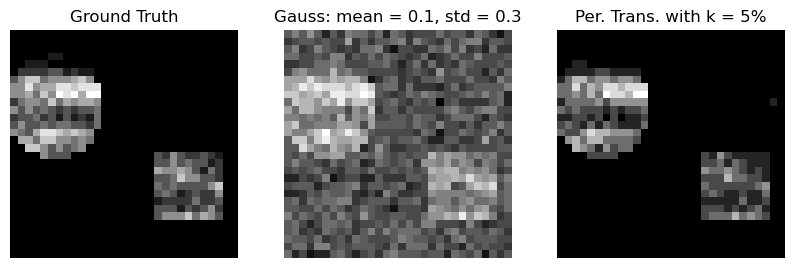

In [19]:
data = read_data("data/image_data.RData")
images = [data]
noisy_data = add_gaussian_noise(data, mean = 0.1, std = 0.3, seed=123)
#noisy_data = add_poisson_noise(data, lam = 0.2, seed=123)
images.append(noisy_data)
percantage_pt = getPersistenceTransformation2(data_X = pd.DataFrame(noisy_data), listOfK = [0.05])
images.append(percantage_pt[0])
labels = ['Ground Truth', 'Gauss: mean = 0.1, std = 0.3', 'Per. Trans. with k = 5%']
#labels = ['Ground Truth', 'Poisson: lam = 0.2', 'Per. Trans. with k = 5%']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
for i in range(3):
    axes[i].imshow(create_maldi_image(images[i]), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(labels[i])
plt.savefig('plot.png')
plt.show()

In [27]:
#print(signal_to_noise_ratio(images[0], images[0]))
#print(signal_to_noise_ratio(images[0], images[1]))
#print(signal_to_noise_ratio(images[0], images[2]))

0.0
0.3164717545629117
0.10419725713039699


In [50]:
data = read_data("data/image_data_baseline_15.RData")
images = [data]
noisy_data = add_gaussian_noise(data, mean = 0.1, std = 0.3, seed=123)
#noisy_data = add_poisson_noise(data, lam = 0.2, seed=123)
images.append(noisy_data)

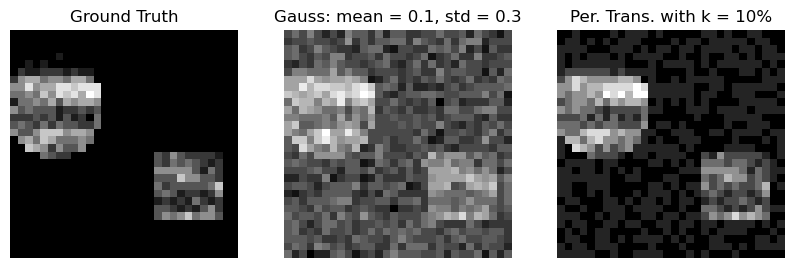

In [51]:
percantage_pt = getPersistenceTransformation2(data_X = pd.DataFrame(noisy_data), listOfK = [0.1])
images.append(percantage_pt[0])
labels = ['Ground Truth', 'Gauss: mean = 0.1, std = 0.3', 'Per. Trans. with k = 10%']
#labels = ['Ground Truth', 'Poisson: lam = 0.2', 'Per. Trans. with k = 5%']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
for i in range(3):
    axes[i].imshow(create_maldi_image(images[i]), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(labels[i])
plt.savefig('plot.png')
plt.show()

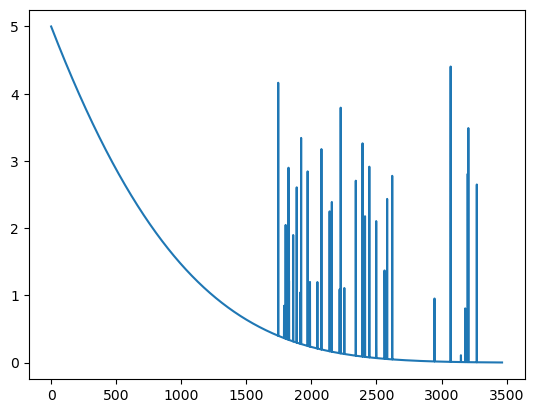

In [40]:
plt.plot(data[560])
plt.show()

In [ ]:
plt.plot(percantage_pt[0][560])
plt.show()

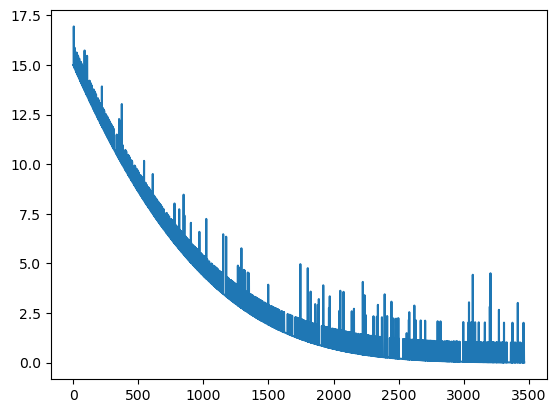

In [43]:
plt.plot(noisy_data[560])
plt.show()

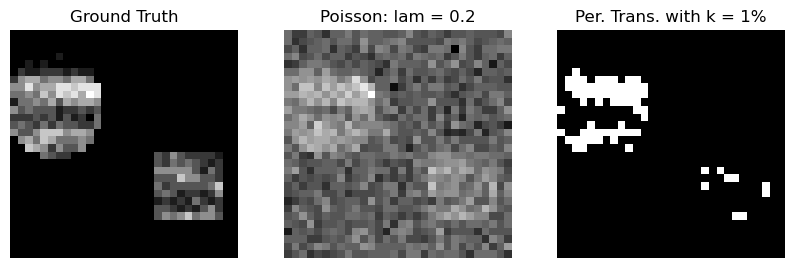

In [42]:
data = read_data("data/image_data_baseline_15.RData")
images = [data]
#noisy_data = add_gaussian_noise(data, mean = 0.1, std = 0.3, seed=123)
noisy_data = add_poisson_noise(data, lam = 0.2, seed=123)
images.append(noisy_data)
percantage_pt = getPersistenceTransformation2(data_X = pd.DataFrame(noisy_data), listOfK = [0.01])
images.append(percantage_pt[0])
labels = ['Ground Truth', 'Poisson: lam = 0.2', 'Per. Trans. with k = 1%']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
for i in range(3):
    axes[i].imshow(create_maldi_image(images[i]), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(labels[i])
plt.savefig('plot.png')
plt.show()

In [25]:
print(signal_to_noise_ratio(images[0], images[0]))
print(signal_to_noise_ratio(images[0], images[1]))
print(signal_to_noise_ratio(images[0], images[2]))

0.0
0.4364795287266981
0.06545057275357016


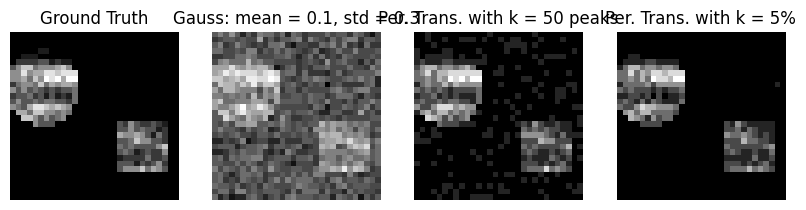

In [28]:
data = read_data("data/image_data.RData")
images = [data]
noisy_data = add_gaussian_noise(data, mean = 0.1, std = 0.3, seed=123)
#noisy_data = add_poisson_noise(data, lam = 0.2, seed=123)
images.append(noisy_data)
fixed_pt = getPersistenceTransformation(data_X = pd.DataFrame(noisy_data), number_of_peaks = 50)
images.append(fixed_pt)
percantage_pt = getPersistenceTransformation2(data_X = pd.DataFrame(noisy_data), listOfK = [0.05])
images.append(percantage_pt[0])
labels = ['Ground Truth', 'Gauss: mean = 0.1, std = 0.3',  'Per. Trans. with k = 50 peaks', 'Per. Trans. with k = 5%']
#labels = ['Ground Truth', 'Poisson: lam = 0.2', 'Per. Trans. with k = 5%']

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 10))
for i in range(4):
    axes[i].imshow(create_maldi_image(images[i]), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(labels[i])
plt.savefig('plot.png')
plt.show()

In [35]:
print(signal_to_noise_ratio(images[0], images[0]))
print(signal_to_noise_ratio(images[0], images[1]))
print(signal_to_noise_ratio(images[0], images[2]))
print(signal_to_noise_ratio(images[0], images[3]))

0.03769424780864235
0.328360551587035
0.11284391517530001
0.12160194830755722


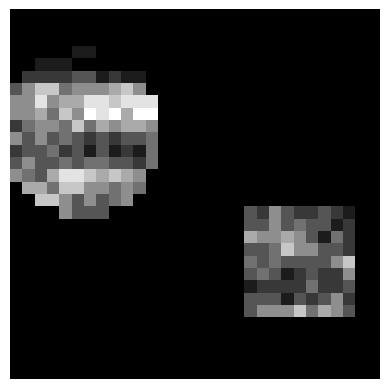

In [14]:
data = read_data("data/image_data.RData")
image = create_maldi_image(data)
plot_image(image)

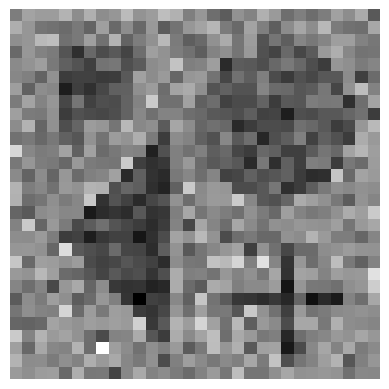

In [53]:
data = read_csv_data("data/data.csv")
image = create_maldi_image(data)
plot_image(image)

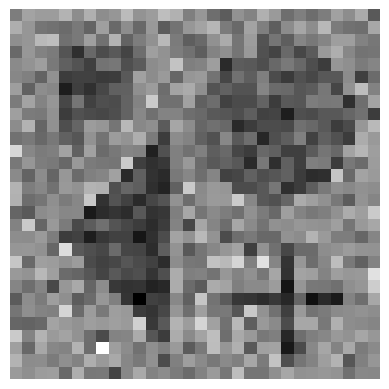

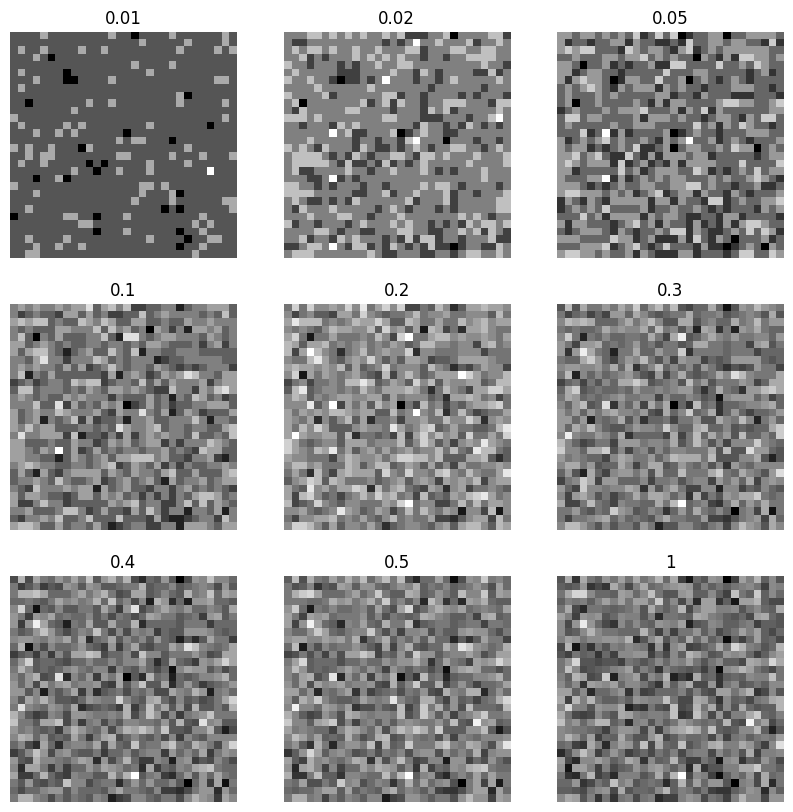

In [65]:
data = read_csv_data("data/data.csv")
plot_image(create_maldi_image(data))
#X0 = getPersistenceTransformation(data_X = pd.DataFrame(data), number_of_peaks = 50)
#plot_image(create_maldi_image(X0))
X = getPersistenceTransformation2(data_X = pd.DataFrame(data), listOfK = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1])
labels = ['0.01', '0.02', '0.05', '0.1', '0.2', '0.3', '0.4', '0.5', '1']
plot_images(X, labels)

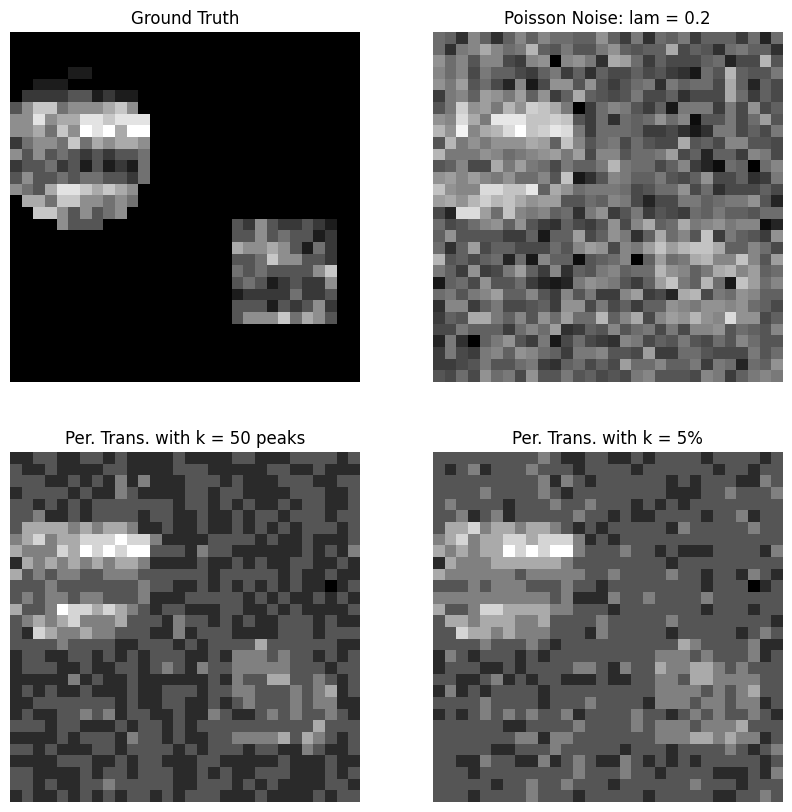

In [12]:
data = read_data("data/image_data.RData")
images = [data]
noisy_data = add_poisson_noise(data, lam = 0.4, seed=123)
images.append(noisy_data)
fixed_pt = getPersistenceTransformation(data_X = pd.DataFrame(noisy_data), number_of_peaks = 50)
images.append(fixed_pt)
percantage_pt = getPersistenceTransformation2(data_X = pd.DataFrame(noisy_data), listOfK = [0.05])
images.append(percantage_pt[0])
labels = ['Ground Truth', 'Poisson Noise: lam = 0.2', 'Per. Trans. with k = 50 peaks', 'Per. Trans. with k = 5%']
plot_images(images, labels)

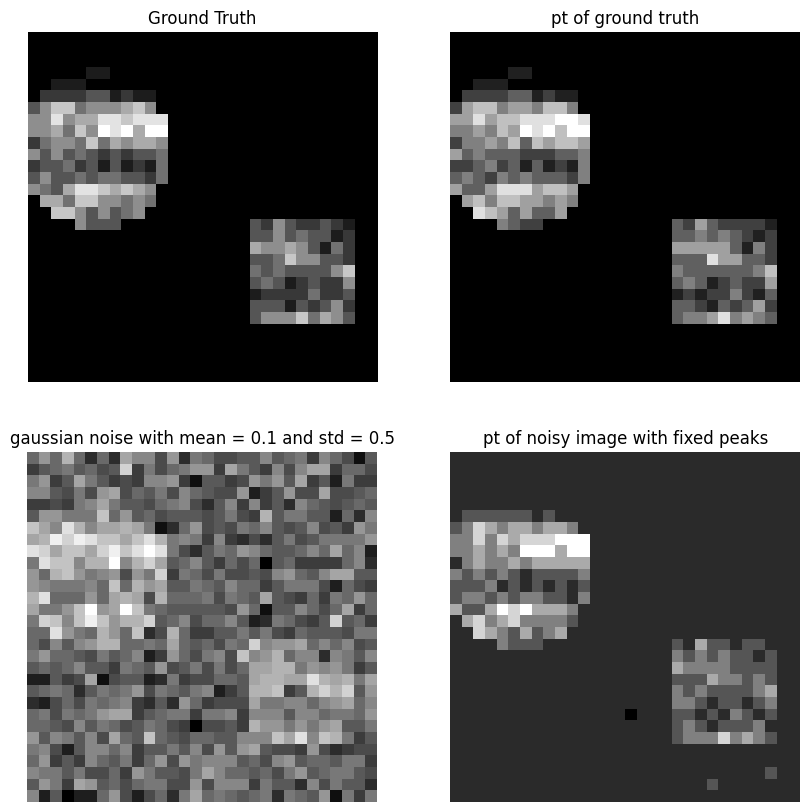

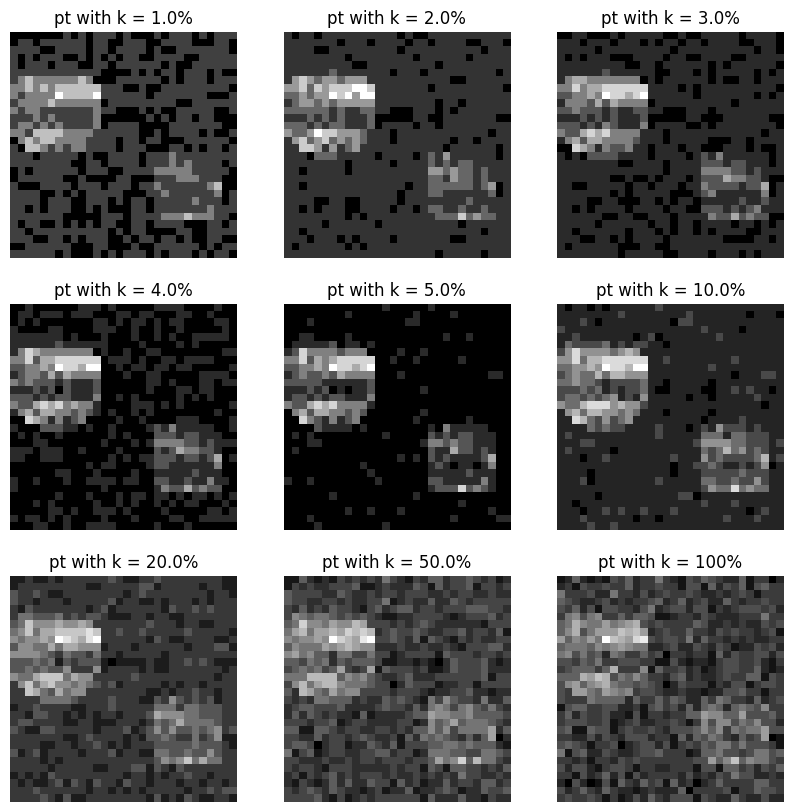

In [55]:
apply_pt(data = read_data("data/image_data.RData"), noise_type = 'gaussian', list_of_k = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.5, 1], mean = 0.1, std = 0.5, seed = 123)

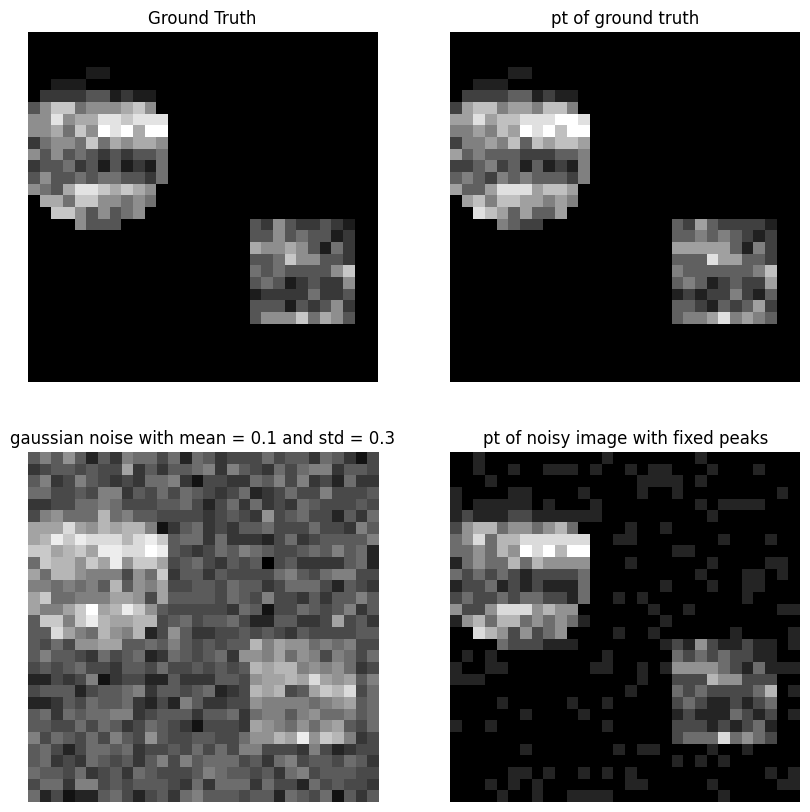

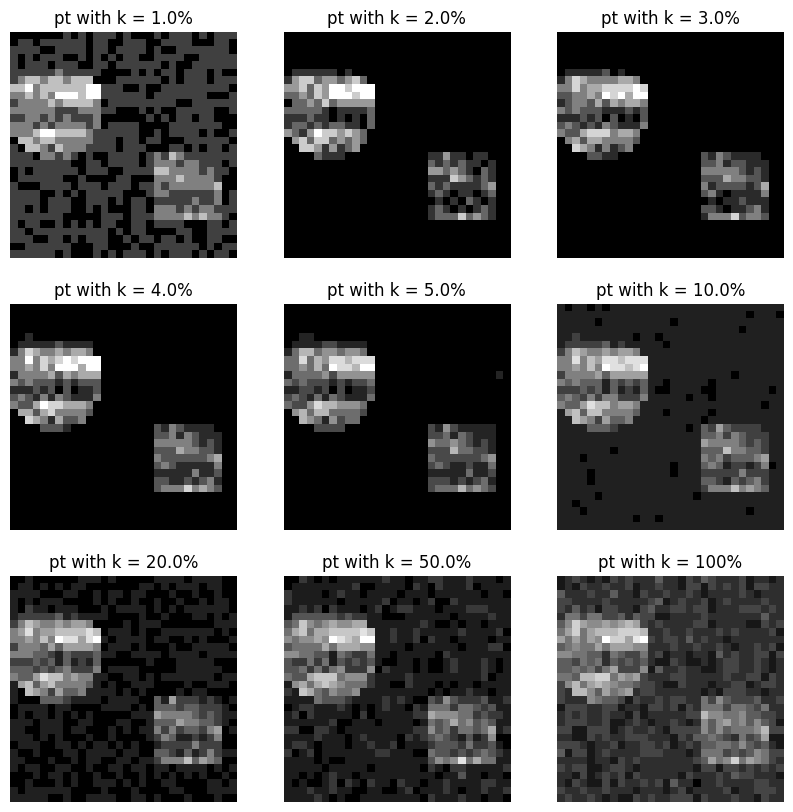

In [56]:
apply_pt(data = read_data("data/image_data.RData"), noise_type = 'gaussian', list_of_k = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.5, 1], mean = 0.1, std = 0.3, seed = 123)

In [70]:
apply_pt(data = read_data("data/image_data.RData"), noise_type = 'gaussian', list_of_k = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.5, 1], mean = 0.0, std = 0.2, seed = 123)

KeyboardInterrupt: 

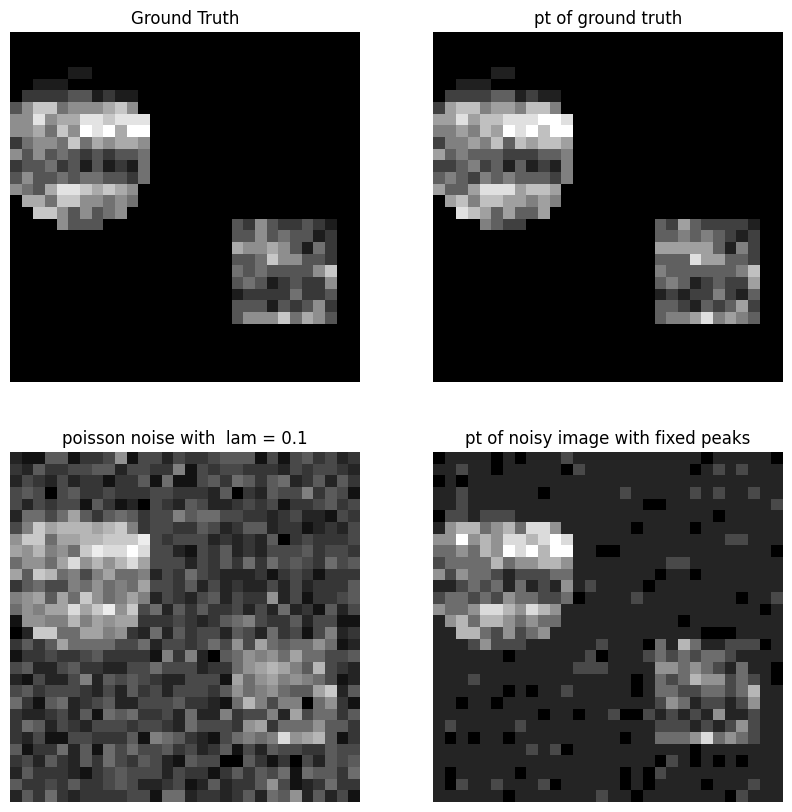

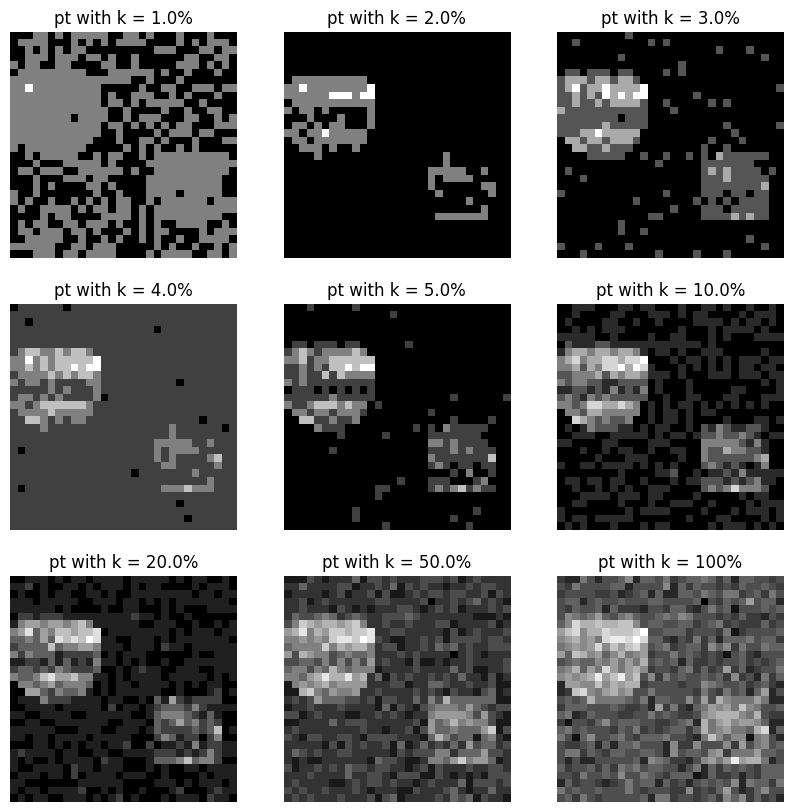

In [68]:
apply_pt(data = read_data("data/image_data.RData"), noise_type = 'poisson', list_of_k = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.5, 1], lam = .1, seed = 123)

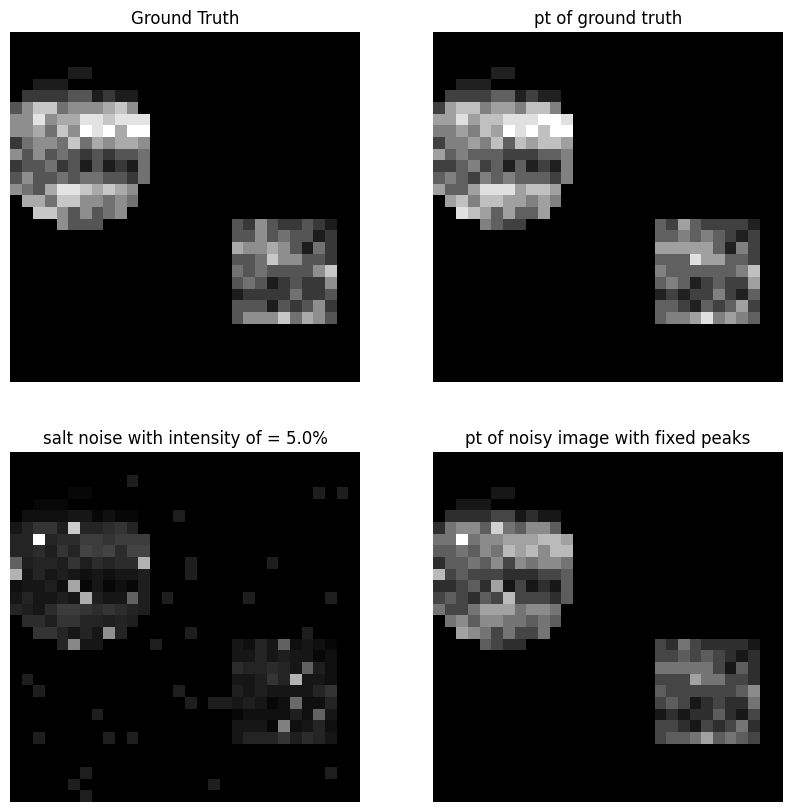

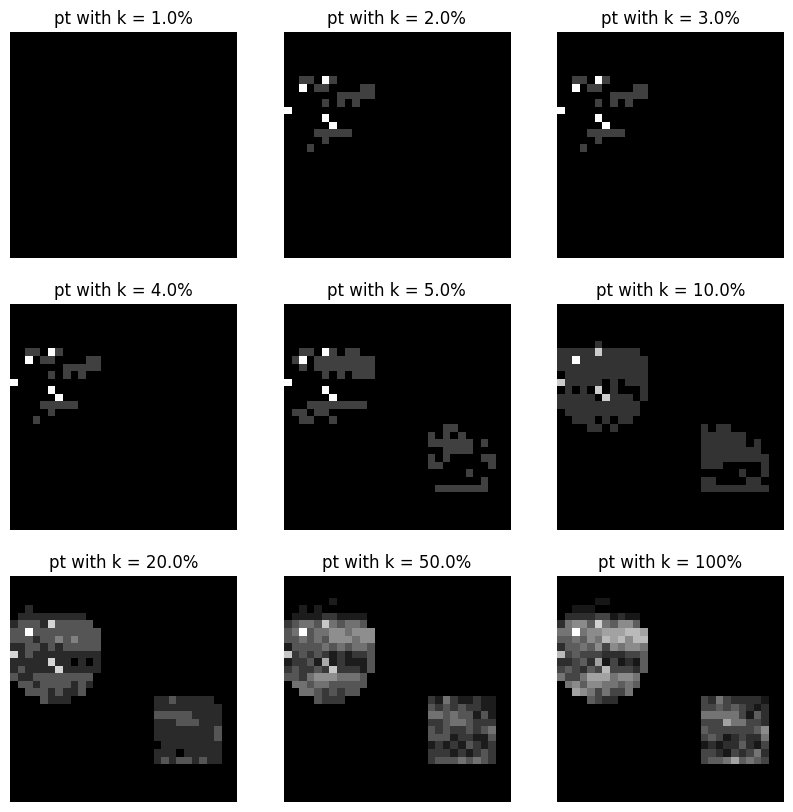

In [148]:
apply_pt(data = read_data("data/image_data.RData"), noise_type = 'salt', list_of_k = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.5, 1], percentage = .05)

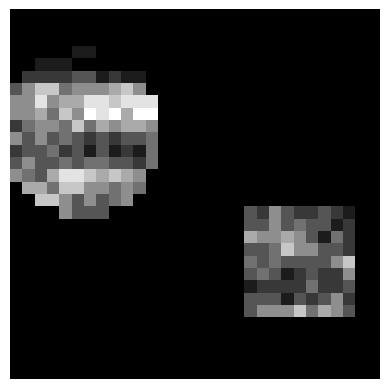

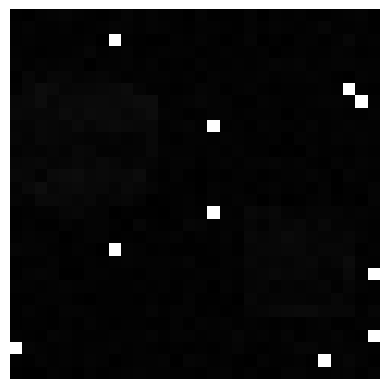

In [84]:
data = read_data("data/image_data.RData")
plot_image(create_maldi_image(data))
noisy_data = add_gaussian_noise(data, mean = 0.01, std = 0.3, seed = 2)
plot_image(create_maldi_image(noisy_data))

In [160]:
apply_pt(data = read_data("data/image_data.RData"), noise_type = 'pepper', list_of_k = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.5, 1], percentage = .5)

KeyboardInterrupt: 

In [ ]:
#data_noisy = read_data("data/image_data_noise.RData")
#image_noisy = create_maldi_image(data_noisy)
#plot_image(image_noisy)
#X = getPersistenceTransformation(data_X = pd.DataFrame(data_noisy), number_of_peaks = 50)
#plot_image(create_maldi_image(X))

In [ ]:
#data_noisy = read_data("data/image_data_noise.RData")
#image_noisy = create_maldi_image(data_noisy)
#plot_image(image_noisy)
#X = getPersistenceTransformation2(data_X = pd.DataFrame(data_noisy), number_of_peaks = 50)
#plot_image(create_maldi_image(X))

In [ ]:
#data_noisy2 = read_data("data/image_data_noise.RData")
#image_noisy2 = create_maldi_image(data_noisy2)
#plot_image(image_noisy2)
#X_list = getPersistenceTransformation2(data_X = pd.DataFrame(data_noisy2), listOfK = [.01, .02, .03, .04, .05])
#plot_images(X_list)